In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
                sep=',',encoding='ISO8859-1')

df_deceased = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
                sep=',',encoding='ISO8859-1')


In [213]:
df_confirmed.head(40)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,50,53,59,70,75,82,114,147
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,461,502,511,581,639,639,701,773,839,825
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,138,150,150,160,178,178,200,212,226,243
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,93,99,117,129,149,149,197,238,428,566
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,21,27,32,32,39,46,64,64,73,103
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,28,38,48,55,65,65,92,112,134,171
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,11,11,15,18,21,21,36,49,57,71
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,13,15,15,18,20,20,35,46,61,68
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,1,2,2,2,3,3,5,7,7,7


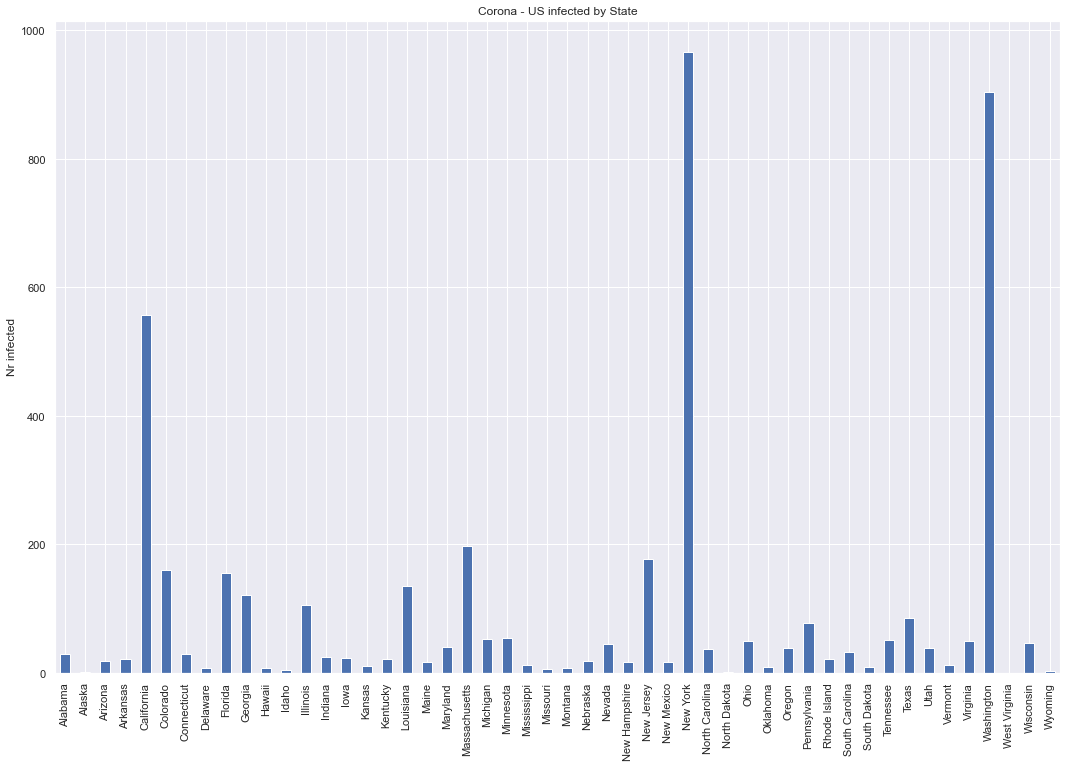

In [214]:
us = df_confirmed.groupby('Country/Region').get_group('US')
us_states = us.groupby('Province/State').sum()
us_states.reset_index(inplace=True)
us_states['state'] = us_states['Province/State']


city_state = us_states['Province/State'].str.split(',',expand=True)
city_state.columns = ['city','state']

state_map = pd.read_csv('../../corona/us_states.csv',sep=';',names=['statename','abb'],header=None)
state_map.set_index('statename',inplace=True)

missing_mask = city_state['state'].isnull()
non_missing_mask = ~city_state['state'].isnull()

missing_states = city_state[missing_mask]
missing_states = missing_states.reset_index().merge(state_map,left_on='city',right_on='statename',how='outer')
missing_states.drop(['city','state'],axis=1,inplace=True)
missing_states.set_index('index',inplace=True)

us_states.loc[missing_states.index,'state'] = missing_states['abb']
#foo = us_states.loc[non_missing_mask,'state'].apply(lambda x : x.split(',')[1])
#us_states.loc[non_missing_mask,'state'] = foo
us_states
us_states = us_states[missing_mask]
us_states

us_states.set_index('Province/State',inplace=True)
us_states.drop(['Lat','Long','state'],axis=1,inplace=True)
us_states = us_states.join(state_map,how='inner')
us_states.drop('abb',axis=1,inplace=True)
plt.figure(figsize=(18,12))
plt.title('Corona - US infected by State')
plt.ylabel('Nr infected')
us_states.iloc[:,-1].plot(kind='bar')
plt.savefig('us_infected_by_state.jpg',format='jpg')

In [215]:
countries = df_confirmed['Country/Region'].unique()
#sorted(countries)

In [216]:

all_countries = pd.DataFrame()

for c in countries:
    temp = df_confirmed[df_confirmed['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries = pd.concat([all_countries,temp],axis=1)

def create_country_df(country):
    
    confirmed = all_countries[country]
    confirmed.index = pd.to_datetime(confirmed.index)
    factor = confirmed / confirmed.shift()
    data = pd.concat([confirmed,factor],axis=1)
    data.columns = ['confirmed','factor']
    data.factor.replace(np.inf,np.nan,inplace=True)
    data['inc'] = data['confirmed'] - data['confirmed'].shift()
    return data

confirmed_dict = dict()

for c in countries:
    confirmed_dict[c] = create_country_df(c)
    
thai = confirmed_dict['Thailand']
swe = confirmed_dict['Sweden']
ita = confirmed_dict['Italy']
korea = confirmed_dict['Korea, South']
us = confirmed_dict['US']
spain = confirmed_dict['Spain']



In [217]:
global_confirmed = df_confirmed.iloc[:,5:].sum()


In [218]:
global_deceased = df_deceased.iloc[:,5:].sum()
global_deceased.index = pd.to_datetime(global_deceased.index)
global_confirmed = df_confirmed.iloc[:,5:].sum()
global_confirmed.index = pd.to_datetime(global_confirmed.index)

global_data = pd.DataFrame(global_confirmed,columns=['confirmed'])
global_data['factor'] = global_data['confirmed'] / global_data['confirmed'].shift()
global_data['inc'] = global_data['confirmed'] - global_data['confirmed'].shift()
global_data['dead'] = global_deceased
global_data['dead_factor'] = global_data['dead'] / global_data['dead'].shift()
global_data['dead_inc'] = global_data['dead'] - global_data['dead'].shift()
global_data['pct_dead'] = 100 * global_data['dead'] /global_data['confirmed']
global_data.index = pd.to_datetime(global_data.index)
global_data.tail(10)

,confirmed,factor,inc,dead,dead_factor,dead_inc,pct_dead
2020-03-07,105821,1.039662,4037.0,3558,1.028324,98.0,3.362282
2020-03-08,109795,1.037554,3974.0,3802,1.068578,244.0,3.462817
2020-03-09,113561,1.034300,3766.0,3988,1.048922,186.0,3.511769
2020-03-10,118592,1.044302,5031.0,4262,1.068706,274.0,3.593834
2020-03-11,125865,1.061328,7273.0,4615,1.082825,353.0,3.666627
2020-03-12,128343,1.019688,2478.0,4720,1.022752,105.0,3.677645
2020-03-13,145193,1.131289,16850.0,5404,1.144915,684.0,3.721943
2020-03-14,156097,1.075100,10904.0,5819,1.076795,415.0,3.727810
2020-03-15,167449,1.072724,11352.0,6440,1.106719,621.0,3.845947
2020-03-16,181546,1.084187,14097.0,7126,1.106522,686.0,3.925176


/usr/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


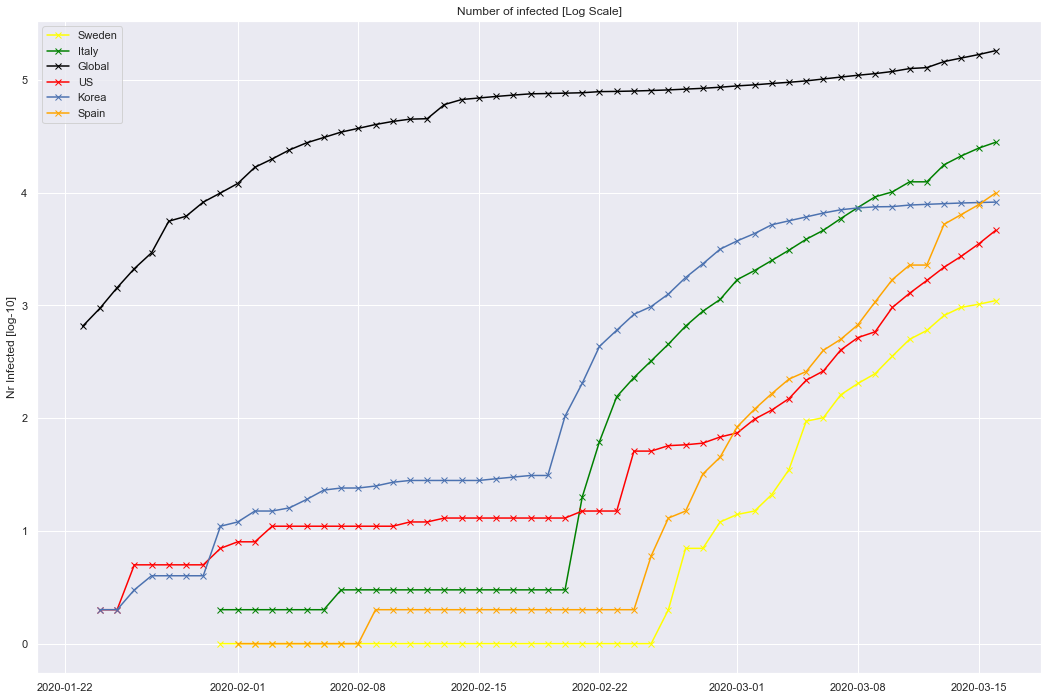

In [219]:
global_conf = np.log10(global_confirmed)

swe_conf = swe.loc[swe['confirmed'] > 0]
swe_conf = np.log10(swe_conf['confirmed'])
ita_conf = ita.loc[ita['confirmed'] > 0]
ita_conf = np.log10(ita_conf['confirmed'])
us_conf = us.loc[us['confirmed'] > 0]
us_conf = np.log10(us_conf['confirmed'])
korea_conf = korea.loc[korea['confirmed'] > 0]
korea_conf = np.log10(korea_conf['confirmed'])
spain_conf = spain.loc[spain['confirmed'] > 0]
spain_conf = np.log10(spain['confirmed'])

plt.figure(figsize=(18,12))
plt.title('Number of infected [Log Scale]')
plt.plot(swe_conf,'x-',color='yellow',label='Sweden')
plt.plot(ita_conf,'x-',color='green',label='Italy')
plt.plot(global_conf,'x-',color='black',label='Global')
plt.plot(us_conf,'x-',color='red',label='US')
plt.plot(korea_conf,'x-',color='b',label='Korea')
plt.plot(spain_conf,'x-',color='orange',label='Spain')
plt.ylabel('Nr Infected [log-10]')
plt.legend(loc='upper left')
plt.savefig('corona_evolution_countries_log.jpg',format='jpg')

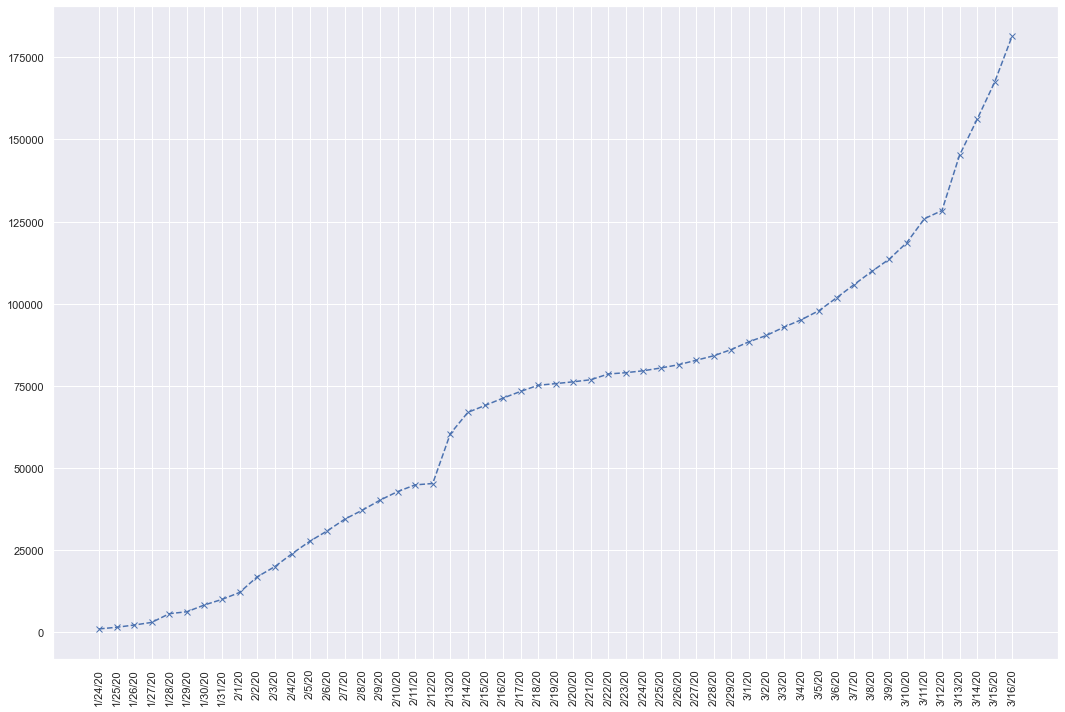

In [220]:
global_series = all_countries.sum(axis=1)
_= plt.figure(figsize=(18,12))
_= plt.plot(global_series,'x--')
_= plt.xticks(rotation=90)



In [221]:
df_deceased = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
                sep=',',encoding='ISO8859-1')
df_deceased.head()

#countries_deceased = df_deceased['Country/Region'].unique()

countries_deceased = countries
all_countries_deceased = pd.DataFrame()

for c in countries_deceased:
    temp = df_deceased[df_deceased['Country/Region'] == c]
    temp = temp.groupby('Country/Region')
    temp = temp.sum().iloc[:,4:]
    temp = temp.T

    all_countries_deceased = pd.concat([all_countries_deceased,temp],axis=1)

def create_deceased_df(country):
    
    deceased = all_countries_deceased[country]
    deceased.index = pd.to_datetime(deceased.index)
    factor = deceased / deceased.shift()

    data = pd.concat([deceased,factor],axis=1)
    data.columns = ['deceased','dead_factor']
    data.dead_factor.replace(np.inf,np.nan,inplace=True)
    data['dead_inc'] = data['deceased'] - data['deceased'].shift()
    return data

deceased_dict = dict()

for c in countries_deceased:
    deceased_dict[c] = create_deceased_df(c)




In [222]:
country_data = dict()

for c in countries:
    country_data[c] = pd.concat([confirmed_dict[c],deceased_dict[c]],axis=1)
    country_data[c]['pct_dead'] = 100 * country_data[c]['deceased'] / country_data[c]['confirmed']
    
import pickle

with open ('country_data.pkl','wb') as f:
    pickle.dump(country_data,f,protocol=pickle.HIGHEST_PROTOCOL)
    
ita = country_data['Italy']
swe = country_data['Sweden']
esp = country_data['Spain']
#iran = country_data['Iran']
swe


,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead
2020-01-24,0,NaN,NaN,0,NaN,NaN,NaN
2020-01-25,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-26,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-27,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-28,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-29,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-30,0,NaN,0.0,0,NaN,0.0,NaN
2020-01-31,1,NaN,1.0,0,NaN,0.0,0.000000
2020-02-01,1,1.000000,0.0,0,NaN,0.0,0.000000
2020-02-02,1,1.000000,0.0,0,NaN,0.0,0.000000


(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.]),
 <a list of 7 Text major ticklabel objects>)

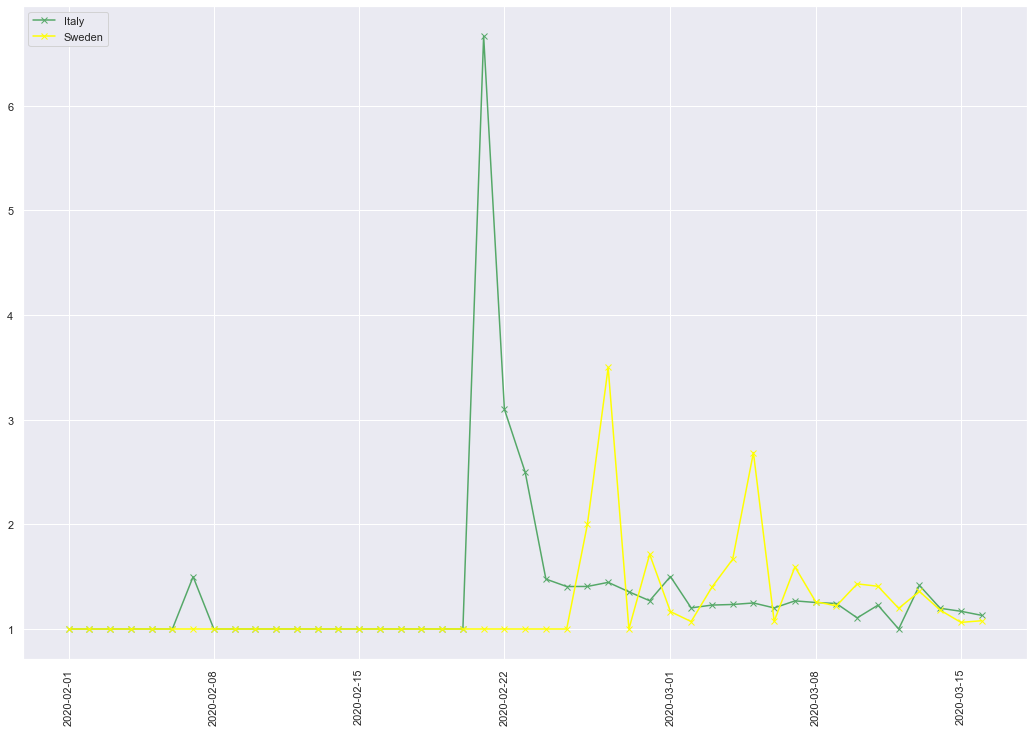

In [223]:
plt.figure(figsize=(18,12))
plt.plot(ita['factor'],'x-',label='Italy',color='g')
plt.plot(swe['factor'],'x-',label='Sweden',color='yellow')
plt.legend(loc='upper left')
plt.xticks(rotation=90)